In [1]:
import whynot as wn
import numpy as np
from sklearn.svm import SVC
from whynot import repeated_classification
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Two Gaussians

Visualize generated distribution, intended to look like graph on [page 3](https://arxiv.org/pdf/1806.08010.pdf)

init:
State(expected_populations=array([1000, 1000]), populations=array([1000, 1000]), features=array([[-0.77772302,  0.1576571 ],
       [-1.92419207,  0.59477888],
       [-1.02722383,  1.60756065],
       ...,
       [ 0.99399113, -1.1371566 ],
       [ 1.67438921, -0.28905644],
       [-0.20357598,  0.90431934]]), labels=array([1, 1, 1, ..., 0, 1, 1]), classifier_params=array([0.02708867, 3.79396743, 0.0417196 ]), risks=array([0.165, 0.184]))


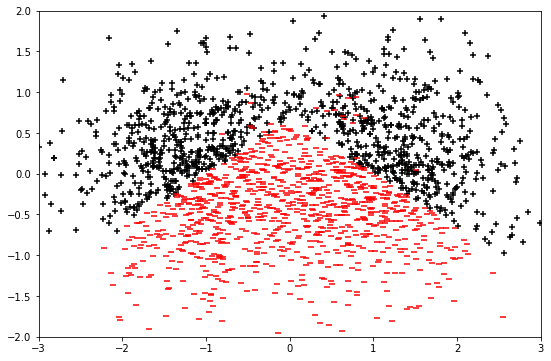

In [2]:
def graph_two_gaussians(features, labels, params=None):
    plt.figure(figsize=(9, 6))

    plt.scatter(*features[labels.astype(bool)].T, marker='+', color='k')
    plt.scatter(*features[(1 - labels).astype(bool)].T, marker='_', color='r')
    
    xlims = np.array([-3, 3])
    if params is not None:
        plt.plot(xlims, -params[0] / params[1] * xlims - params[2] / params[1], color='b')

    plt.xlim(xlims)
    plt.ylim((-2, 2))

    plt.show()


init = repeated_classification.experiments.sample_initial_states_gaussians(np.random.RandomState())
print('init:\n' + str(init))

graph_two_gaussians(init.features, init.labels)

Run to see progress at each step

In [4]:
import whynot as wn
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from whynot import repeated_classification
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

repeated_classification.TwoGaussiansExperiment.run(1)


0: expected pops [1584.1905 1589.0404], risks [0.1792 0.1894], params [-3.9188e-02  3.7601e+00 -1.3130e-04]
20: expected pops [2314.9842 2321.4916], risks [0.1815 0.1998], params [-0.0336  3.5821  0.0246]
40: expected pops [2087.5507 2574.4227], risks [0.2011 0.1789], params [0.1026 3.6635 0.0243]
60: expected pops [2309.0848 2396.2824], risks [0.1905 0.1936], params [9.6497e-03 3.5383e+00 2.6416e-03]
80: expected pops [2240.392  2314.2433], risks [0.1816 0.1791], params [-0.0388  3.8104  0.    ]
100: expected pops [2206.6259 2396.8191], risks [0.178  0.1896], params [ 0.0083  3.6296 -0.1056]
120: expected pops [2328.8432 2277.8556], risks [0.1806 0.1864], params [-2.8368e-03  3.6579e+00  4.3640e-02]
140: expected pops [2162.0774 2445.5048], risks [0.1951 0.1905], params [0.0381 3.4736 0.0128]
160: expected pops [2390.0025 2250.4607], risks [0.1816 0.1804], params [-0.0232  3.9329 -0.0645]
180: expected pops [2170.9214 2265.8139], risks [0.1785 0.1803], params [0.0314 3.7511 0.0217]
2

Dataset(covariates=array([[0]]), treatments=array([0]), outcomes=array([0.18721835]), true_effects=array([-0.00842317]), causal_graph=None)

Using `scipy.optimize.minimize` generally fits slightly better than using linear SVM

In [5]:
config = repeated_classification.experiments.construct_config_gaussians()
rng = np.random.RandomState()

POPULATIONS = [2000, 500]  # modify

features, labels = [], []
for pop, dist in list(zip(POPULATIONS, config.group_distributions)):
    features_k, labels_k = dist(pop, rng)
    features.append(features_k)
    labels.append(labels_k)
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# SVM
c_values = [0.01, 0.1, 1, 10]
models = [SVC(C=c, kernel='linear').fit(features, labels) for c in c_values]
params = [np.concatenate([m.coef_.flatten(), m.intercept_.flatten()]) for m in models]
accuracies = [
    np.count_nonzero(labels == repeated_classification.experiments.linear_classifier_2d(features, p, None))
    for p in params
]
for (c, acc) in zip(c_values, accuracies):
    print('linear SVM with C = {: >6.2f} :  {:>6d} / {} correct'.format(c, acc, len(labels)))

# Logistic regression
penalties = ['l1', 'l2']
models = [LogisticRegression(penalty=p).fit(features, labels) for p in penalties]
params = [np.concatenate([m.coef_.flatten(), m.intercept_.flatten()]) for m in models]
accuracies = [
    np.count_nonzero(labels == repeated_classification.experiments.linear_classifier_2d(features, p, None))
    for p in params
]
for (p, acc) in zip(penalties, accuracies):
    print('Logistic regression with {} :  {:>6d} / {} correct'.format(p, acc, len(labels)))

# ERM with scipy.optimize.minimize
erm_params = repeated_classification.experiments.erm(
    config,
    features,
    labels,
    [0, 1, 0],
    rng,
    method='Powell'
)
erm_acc = np.count_nonzero(
    labels == repeated_classification.experiments.linear_classifier_2d(features, erm_params, None)
)
print('scipy.optimize.minimize    :  {: >6d} / {} correct'.format(erm_acc, len(labels)))

linear SVM with C =   0.01 :    2070 / 2500 correct
linear SVM with C =   0.10 :    2066 / 2500 correct
linear SVM with C =   1.00 :    2071 / 2500 correct
linear SVM with C =  10.00 :    2069 / 2500 correct
Logistic regression with l1 :    2064 / 2500 correct
Logistic regression with l2 :    2066 / 2500 correct
scipy.optimize.minimize    :    2251 / 2500 correct


# Median Estimation

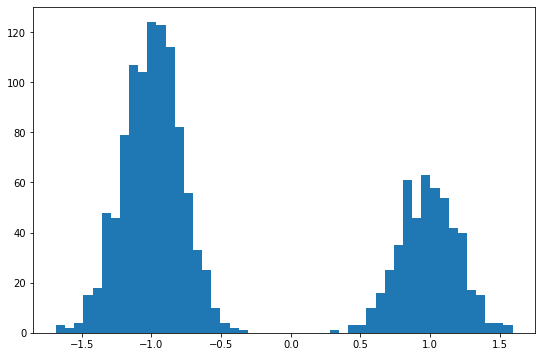

In [6]:
def graph_median_setup(pop1, pop2):
    data = np.concatenate([np.random.normal(-1, 0.2, pop1), np.random.normal(1, 0.2, pop2)], axis=0)
    plt.figure(figsize=(9, 6))
    plt.hist(data, bins=50)
    plt.show()


graph_median_setup(1000, 500)

In [7]:
import whynot as wn
import numpy as np
from sklearn.svm import SVC
from whynot import repeated_classification
import matplotlib.pyplot as plt
%matplotlib inline

repeated_classification.MedianEstimationExperiment.run(1, parallelize=False)


0: expected pops [1365.5552 1362.1342], risks [0.4823 1.5168], params [-0.5147]
20: expected pops [6368.319  1166.4715], risks [0.1645 1.9597], params [-0.9537]
40: expected pops [6620.6543 1165.8878], risks [0.1603 1.9497], params [-0.9493]
60: expected pops [6606.7429 1165.0504], risks [0.1613 1.9535], params [-0.9569]
80: expected pops [6600.8614 1165.4812], risks [0.1604 1.9514], params [-0.9563]
100: expected pops [6629.886 1166.805], risks [0.1636 1.9475], params [-0.9524]
120: expected pops [6633.8233 1165.6729], risks [0.1633 1.9533], params [-0.9539]
140: expected pops [6617.6033 1164.9357], risks [0.1623 1.9602], params [-0.9581]
160: expected pops [6632.8483 1164.2678], risks [0.1617 1.9501], params [-0.9549]
180: expected pops [6644.8713 1166.2583], risks [0.1636 1.9634], params [-0.9558]

0: expected pops [1365.5552 1362.1342], risks [0.9905 1.0074], params [-0.0054]
20: expected pops [1580.0383 1586.7064], risks [0.9952 1.0017], params [-0.0067]
40: expected pops [1579.7

Dataset(covariates=array([[0]]), treatments=array([1]), outcomes=array([1.0085]), true_effects=array([-0.9414]), causal_graph=None)

two gaussians:
logistic regression with not 0-1 loss
different retention




Walk through how to run this experiment

Intervention on retention dynamics

some kind of dynamic intervention to showcase more of whynot

performative prediction

In [8]:
MedianEstimationExperiment = DynamicsExperiment(
    name="MedianEstimationExperiment",
    description="",  # TODO: description
    simulator=repeated_classification,
    simulator_config=construct_config_median,
    intervention=repeated_classification.Intervention(time=0, train_classifier=dro),
    state_sampler=sample_initial_states_median,
    propensity_scorer=0.5,
    outcome_extractor=extract_outcomes,
    covariate_builder=lambda run: 0,  # TODO: change
)

NameError: name 'DynamicsExperiment' is not defined

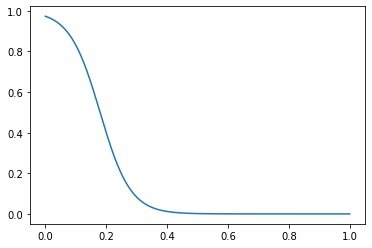

In [3]:
x = np.linspace(0, 1, 1000)
k = 20
f = lambda x: np.exp(-np.log(1 + np.exp(k * (x-0.18))))

plt.plot(x, f(x))